<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_function_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="콜랩에서 열기"/></a>

# 자동 생성된 상담원 채팅: 제공된 도구를 기능으로 사용하여 작업 해결

자동 생성은 자동화된 채팅을 통해 공동으로 작업을 수행하는 데 사용할 수 있는 LLM, 툴 또는 사람으로 구동되는 대화형 에이전트를 제공합니다. 이 프레임워크는 다중 에이전트 대화를 통해 툴 사용과 사람의 참여를 허용합니다. 이 기능에 대한 설명서는 [여기](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat)를 참조하세요.

이 노트북에서는 OpenAI 모델(모델 버전 0613)의 새로운 기능인 `AssistantAgent`와 `UserProxyAgent`를 사용하여 함수를 호출하는 방법을 보여드립니다. 에이전트를 초기화하려면 지정된 프롬프트와 함수 구성을 `AssistantAgent`에 전달해야 합니다. 해당 함수는 `AssistantAgent`가 호출한 모든 함수를 실행할 `UserProxyAgent`에 전달되어야 합니다. 설명과 함수를 일치시켜야 하는 이 요구 사항 외에도, `AssistantAgent`의 시스템 메시지를 확인하여 지침이 함수 호출 설명과 일치하는지 확인하는 것이 좋습니다.

요구 사항 ## 요구 사항

자동 생성에는 `Python>=3.8`이 필요합니다. 이 노트북 예제를 실행하려면 `MathUserProxyAgent`에서 함수를 가져올 것이므로 [mathchat] 옵션을 설치해 주세요:
```bash
pip install "pyautogen[mathchat]"
```

In [1]:
# %pip install "pyautogen[mathchat]~=0.1.0"

## API 엔드포인트 설정

`config_list_from_models`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_models) 함수는 제공된 모델 목록에 대해 Azure OpenAI 엔드포인트 및 OpenAI 엔드포인트를 사용하여 구성 목록을 생성하려고 시도합니다. 이 함수는 API 키와 API 베이스가 해당 환경 변수 또는 로컬 txt 파일에 저장되어 있다고 가정합니다:

- OpenAI API 키: os.environ["OPENAI_API_KEY"] 또는 `openai_api_key_file="key_openai.txt"`.
- Azure OpenAI API 키: os.environ["AZURE_OPENAI_API_KEY"] 또는 `aoai_api_key_file="key_aoai.txt"`. 한 줄에 하나씩 여러 개의 키를 저장할 수 있습니다.
- Azure OpenAI API 베이스: os.environ["AZURE_OPENAI_API_BASE"] 또는 `aoai_api_base_file="base_aoai.txt"`. 한 줄에 하나씩 여러 개의 베이스를 저장할 수 있습니다.

OpenAI API 키만 있거나 Azure OpenAI API 키 + 베이스만 있어도 괜찮습니다.
구글 콜랩에서 이 노트북을 열면 왼쪽 패널의 파일 아이콘을 클릭한 다음 '파일 업로드' 아이콘을 선택해 파일을 업로드할 수 있습니다.

다음 코드는 일부 엔드포인트가 아직 기능을 지원하지 않기 때문에 구성 목록에서 Azure OpenAI 엔드포인트를 제외합니다. 엔드포인트가 있는 경우 `exclude` 인수를 제거하세요.

In [2]:
import autogen

config_list = autogen.config_list_from_models(model_list=["gpt-4", "gpt-3.5-turbo", "gpt-3.5-turbo-16k"], exclude="aoai")

구성 목록은 다음과 같습니다:
```python
config_list = [
    {
        '모델': 'gpt-4',
        'api_key': '<여기에 OpenAI API 키 입력>',
    }, # gpt-4용 OpenAI API 엔드포인트
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<여기에 OpenAI API 키 입력>',
    }, # gpt-3.5-turbo용 OpenAI API 엔드포인트
    {
        'model': 'gpt-3.5-turbo-16k',
        'api_key': '<여기 OpenAI API 키>',
    }, # gpt-3.5-turbo-16k용 OpenAI API 엔드포인트
]
```


## 함수 호출 만들기

이 예제에서는 `AssistantAgent`와 `UserProxyAgent`로 함수 호출을 실행하는 방법을 보여드리겠습니다. 기본 시스템 프롬프트인 `AssistantAgent`를 사용하여 LLM 어시스턴트가 코드로 작업을 수행할 수 있도록 하고, `UserProxyAgent`는 LLM 응답에서 코드 블록을 추출하여 이를 실행합니다. 새로운 "function_call" 기능을 사용하여 함수를 정의하고 `AssistantAgent`에 대한 OpenAI 설정에서 함수에 대한 설명을 지정합니다. 그런 다음 `UserProxyAgent`에 함수를 등록합니다.


user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: python *****
Arguments: 
{
  "cell": "
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define basic parameters
face_color = '#FFDDC1'
plt.figure(figsize=(10, 2))

# Agent 1
agent1 = mpatches.FancyBboxPatch((0.02, 0.4), 0.2, 0.6, boxstyle=mpatches.BoxStyle(\"Round\", pad=0.02))
plt.gca().add_artist(agent1)
plt.gca().text(0.12, 0.7, 'Agent 1', ha='center', va='center', fontsize=12, color='blue')

# Agent 2
agent2 = mpatches.FancyBboxPatch((0.45, 0.4), 0.2, 0.6, boxstyle=mpatches.BoxStyle(\"Round\", pad=0.02))
plt.gca().add_artist(agent2)
plt.gca().text(0.55, 0.7, 'Agent 2', ha='center', va='center', fontsize=12, color='red')

# Dialog
plt.gca().text(0.12, 0.35, '\"Hello, how are you?\"', ha='center', va='center', fo

(0.0, 1.0, 0.0, 1.0)

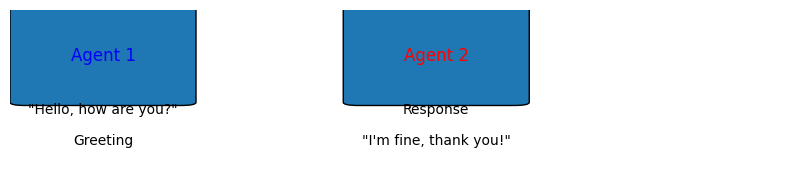

user_proxy (to chatbot):

***** Response from calling function "python" *****
(0.0, 1.0, 0.0, 1.0)
***************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [3]:
llm_config = {
    "functions": [
        {
            "name": "python",
            "description": "run cell in ipython and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "cell": {
                        "type": "string",
                        "description": "Valid Python cell to execute.",
                    }
                },
                "required": ["cell"],
            },
        },
        {
            "name": "sh",
            "description": "run a shell script and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "script": {
                        "type": "string",
                        "description": "Valid shell script to execute.",
                    }
                },
                "required": ["script"],
            },
        },
    ],
    "config_list": config_list,
    "request_timeout": 120,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={"work_dir": "coding"},
)

# define functions according to the function description
from IPython import get_ipython

def exec_python(cell):
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log

def exec_sh(script):
    return user_proxy.execute_code_blocks([("sh", script)])

# register the functions
user_proxy.register_function(
    function_map={
        "python": exec_python,
        "sh": exec_sh,
    }
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
)


## Wolfram Alpha API를 사용한 또 다른 예제

수학 문제를 풀기 위해 Wolfram Alpha API를 쿼리하는 또 다른 예를 제공합니다. 호출 함수로 미리 정의된 함수 `MathUserProxyAgent().execute_one_wolfram_query`를 사용합니다.

In [4]:
import os
from autogen.agentchat.contrib.math_user_proxy_agent import MathUserProxyAgent

# you need to provide a wolfram alpha app id to run this example
if not os.environ.get("WOLFRAM_ALPHA_APPID"):
    os.environ["WOLFRAM_ALPHA_APPID"] = open("wolfram.txt").read().strip()

llm_config = {
    "model": "gpt-4-0613",
    "functions": [
        {
            "name": "query_wolfram",
            "description": "Return the API query result from the Wolfram Alpha. the return is a tuple of (result, is_success).",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The Wolfram Alpha code to be executed.",
                    }
                },
                "required": ["query"],
            },
        }
    ],
    "config_list": config_list,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="Only use the functions you have been provided with. Do not ask the user to perform other actions than executing the functions. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# the key in `function_map` should match the function name in "functions" above
# we register a class instance method directly
user_proxy = autogen.UserProxyAgent(
    "user_proxy",
    max_consecutive_auto_reply=2,
    human_input_mode="NEVER",
    function_map={"query_wolfram": MathUserProxyAgent().execute_one_wolfram_query},
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Problem: Find all $x$ that satisfy the inequality $(2x+10)(x+3)<(3x+9)(x+8)$. Express your answer in interval notation.",
)


user_proxy (to chatbot):

Problem: Find all $x$ that satisfy the inequality $(2x+10)(x+3)<(3x+9)(x+8)$. Express your answer in interval notation.

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: query_wolfram *****
Arguments: 
{
  "query": "solve (2x+10)(x+3)<(3x+9)(x+8) for x"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION query_wolfram...


user_proxy (to chatbot):

***** Response from calling function "query_wolfram" *****
('Assumption: solve (2 x + 10) (x + 3)<(3 x + 9) (x + 8) for x \nAnswer: ans 0: x<-14\nans 1: x>-3\n', True)
**********************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

The solution to the inequality $(2x+10)(x+3)<(3x+9)(x+8)$ is $x \in (-\infty, -14) \cup (-3, +\infty)$. TERMINATE

--------------------------------------------------------------------------------
user_proxy (to chatbot):



--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------
